In [1]:
%pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage

In [6]:
FLIGHT_SALES_PATH = '/home/chk/Documents/univ/maestria/dataton/Datathon/flight_sales.csv'

In [7]:
dtype_options = {
    'Unnamed: 0': 'int64',
    'Flight_ID': 'str',
    'ProductType': 'str',
    'ProductName': 'str',
    'Quantity': 'float64',
    'TotalSales': 'float64',
    'Aeronave': 'str',
    'DepartureStation': 'str',
    'ArrivalStation': 'str',
    'DestinationType': 'str',
    'Origin_Type': 'str',
    'Capacity': 'float64',
    'Passengers': 'float64',
    'Bookings': 'float64'
}

parse_dates = ['STD', 'STA']

flightSales = pd.read_csv(FLIGHT_SALES_PATH, dtype=dtype_options, parse_dates=parse_dates)
flightSales['STD'] = pd.to_datetime(flightSales['STD'])
flightSales['STA'] = pd.to_datetime(flightSales['STA'])
flightSales.head()

,Unnamed: 0,Flight_ID,ProductType,ProductName,Quantity,TotalSales,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings
0,0,a05290288259526edd3601160b10e1de,Botanas,Carne Seca Habanero,1.0,55.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
1,1,a05290288259526edd3601160b10e1de,Botanas,Cheetos,2.0,98.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
2,2,a05290288259526edd3601160b10e1de,Botanas,Ruffles Queso,6.0,294.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
3,3,a05290288259526edd3601160b10e1de,Refrescos,Coca Sin Azucar,2.0,96.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
4,4,a05290288259526edd3601160b10e1de,Licores,Jack And Coke,1.0,72.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0


In [8]:
flightSales['Duration'] = (flightSales['STA'] - flightSales['STD']).dt.total_seconds() / 3600
flightSales['TravelType'] = flightSales['Duration'].apply(lambda x: 'corto' if x < 2.5 else 'largo')
flightSales['PassengerRate'] = flightSales['Passengers'] / flightSales['Capacity'] * 100

In [9]:
salesGrouped = flightSales.groupby(['Origin_Type', 'Destination_Type', 'TravelType', 'STD']).agg({
    'PassengerRate': 'mean',
    'Duration': 'mean',
})
salesGrouped.reset_index(inplace=True)
salesGrouped.rename(columns={'STD': 'ds', 'PassengerRate': 'y'}, inplace=True)
salesGrouped

,Origin_Type,Destination_Type,TravelType,ds,y,Duration
0,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,78.181818,2.0
1,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-03 16:40:00,96.666667,2.0
2,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-05 16:40:00,87.222222,2.0
3,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-06 09:20:00,57.727273,2.0
4,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-07 16:40:00,72.580645,2.0
...,...,...,...,...,...,...
227212,Playa,Playa,largo,2023-10-15 08:55:00,94.444444,3.5
227213,Playa,Playa,largo,2023-10-19 21:05:00,76.881720,3.5
227214,Playa,Playa,largo,2023-10-22 08:55:00,93.548387,3.5
227215,Playa,Playa,largo,2024-04-08 20:45:00,NaN,3.5


In [11]:
tscv = TimeSeriesSplit()

# for train_index, val_index in tscv.split(salesGrouped):
#     train_df = salesGrouped.iloc[train_index]
#     val_df = salesGrouped.iloc[val_index]

train_index, val_index = next(tscv.split(salesGrouped))
train_df = salesGrouped.iloc[train_index]
val_df = salesGrouped.iloc[val_index]

In [3]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [22]:
group_attributes = ['Origin_Type', 'Destination_Type', 'TravelType']
unique_combinations = salesGrouped[group_attributes].drop_duplicates()
preds = list()
train = pd.DataFrame()
validations = pd.DataFrame()

for _, row in unique_combinations.iterrows():
    condicion = (salesGrouped[group_attributes] == row[group_attributes]).all(axis=1)
    filtered_df = salesGrouped[condicion]
    train_index, val_index = next(tscv.split(filtered_df))
    train_df = salesGrouped.iloc[train_index]
    val_df = salesGrouped.iloc[val_index]
    validations = pd.concat([validations, val_df], ignore_index=True)
    train = pd.concat([train, train_df], ignore_index=True)

    m = Prophet(seasonality_mode='additive', yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=True)
    m.fit(train_df)

    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    forecast['Origin_Type'] = row['Origin_Type']
    forecast['Destination_Type'] = row['Destination_Type']
    forecast['TravelType'] = row['TravelType']
    preds.append(forecast[['Origin_Type', 'Destination_Type', 'TravelType', 'ds', 'yhat']])

preds = pd.concat(preds, ignore_index=True)
preds['yhat'] = preds['yhat'].clip(lower=0)
preds = preds.merge(validations, on=['Origin_Type', 'Destination_Type', 'TravelType', 'ds'], how='left')
wmape(preds['y'], preds['yhat'])

01:16:09 - cmdstanpy - INFO - Chain [1] start processing
01:16:09 - cmdstanpy - INFO - Chain [1] done processing
01:16:09 - cmdstanpy - INFO - Chain [1] start processing
01:16:09 - cmdstanpy - INFO - Chain [1] done processing
01:16:10 - cmdstanpy - INFO - Chain [1] start processing
01:16:10 - cmdstanpy - INFO - Chain [1] done processing
01:16:10 - cmdstanpy - INFO - Chain [1] start processing
01:16:10 - cmdstanpy - INFO - Chain [1] done processing
01:16:10 - cmdstanpy - INFO - Chain [1] start processing
01:16:10 - cmdstanpy - INFO - Chain [1] done processing
01:16:10 - cmdstanpy - INFO - Chain [1] start processing
01:16:10 - cmdstanpy - INFO - Chain [1] done processing
01:16:10 - cmdstanpy - INFO - Chain [1] start processing
01:16:10 - cmdstanpy - INFO - Chain [1] done processing
01:16:11 - cmdstanpy - INFO - Chain [1] start processing
01:16:11 - cmdstanpy - INFO - Chain [1] done processing
01:16:11 - cmdstanpy - INFO - Chain [1] start processing
01:16:11 - cmdstanpy - INFO - Chain [1]

0.15349938496058643

In [53]:
wmape(preds['y'], preds['yhat'])

0.15349938496058643

In [38]:
train['unique_id'] = train['Origin_Type'] + '-' + train['Destination_Type'] + '-' + train['TravelType']
validations['unique_id'] = validations['Origin_Type'] + '-' + validations['Destination_Type'] + '-' + validations['TravelType']

In [42]:
naive_model = StatsForecast(models=[Naive(),
                                    SeasonalNaive(season_length=365),
                                    WindowAverage(window_size=365),
                                    SeasonalWindowAverage(window_size=7, season_length=365)],
                                    freq='h',
                                    n_jobs=-1)
naive_model.fit(train[['unique_id', 'ds', 'y']])

StatsForecast(models=[Naive,SeasonalNaive,WindowAverage,SeasWA])

In [63]:
p_naive = naive_model.predict(h=validations['ds'].nunique())
p_naive = p_naive.reset_index().merge(validations, on=['unique_id', 'ds'], how='left')


/home/chk/.local/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [46]:
p_naive

,unique_id,ds,Naive,SeasonalNaive,WindowAverage,SeasWA,Origin_Type,Destination_Type,TravelType,y,Duration
0,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 13:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 14:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 15:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
18573,Ciudad Fronteriza-Ciudad Principal-largo,2024-05-31 03:05:00,78.494621,95.000000,82.486717,83.145271,NaN,NaN,NaN,NaN,NaN
18574,Ciudad Fronteriza-Ciudad Principal-largo,2024-05-31 04:05:00,78.494621,97.311829,82.486717,77.658371,NaN,NaN,NaN,NaN,NaN
18575,Ciudad Fronteriza-Ciudad Principal-largo,2024-05-31 05:05:00,78.494621,97.311829,82.486717,82.744781,NaN,NaN,NaN,NaN,NaN
18576,Ciudad Fronteriza-Ciudad Principal-largo,2024-05-31 06:05:00,78.494621,75.000000,82.486717,78.924728,NaN,NaN,NaN,NaN,NaN


In [73]:
p_naive['y'].isnull().sum()

17900

In [67]:
p2 = p_naive[~p_naive['Naive'].isnull()]

In [69]:
wmape(p2['y'], p2['Naive'])

0.1415808022407296

In [70]:
p = p2

In [72]:
p['y'].values

array([nan, nan, nan, ..., nan, nan, nan])

Naive WMAPE: nan%
SeasonalNaive WMAPE: nan%
WindowAverage WMAPE: nan%
SeasWA WMAPE: nan%


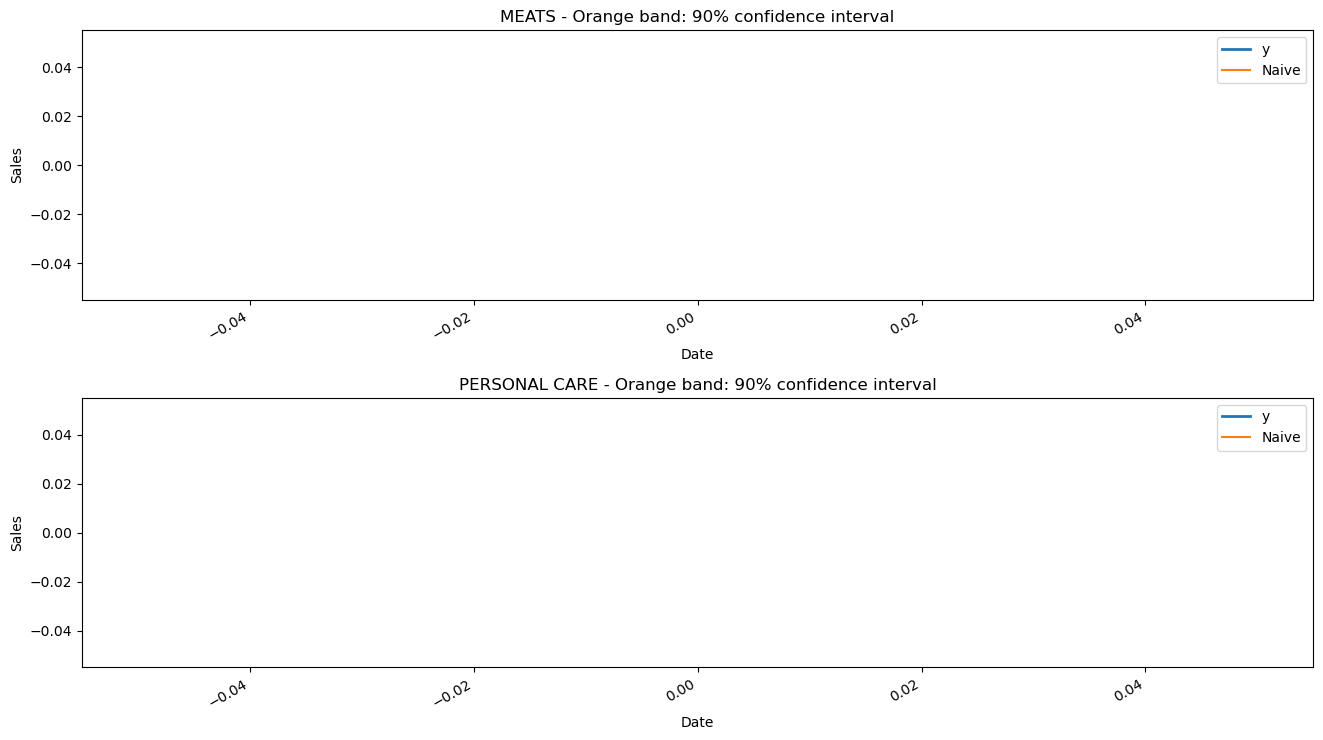

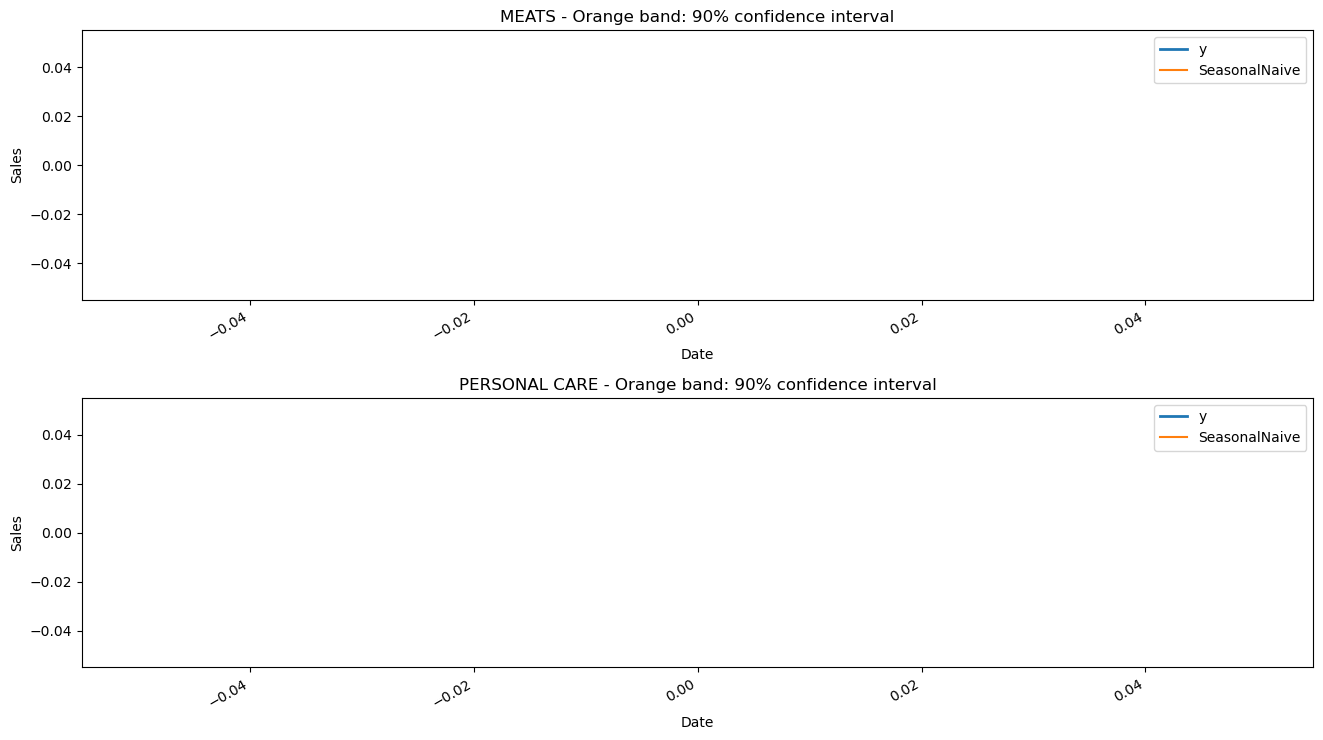

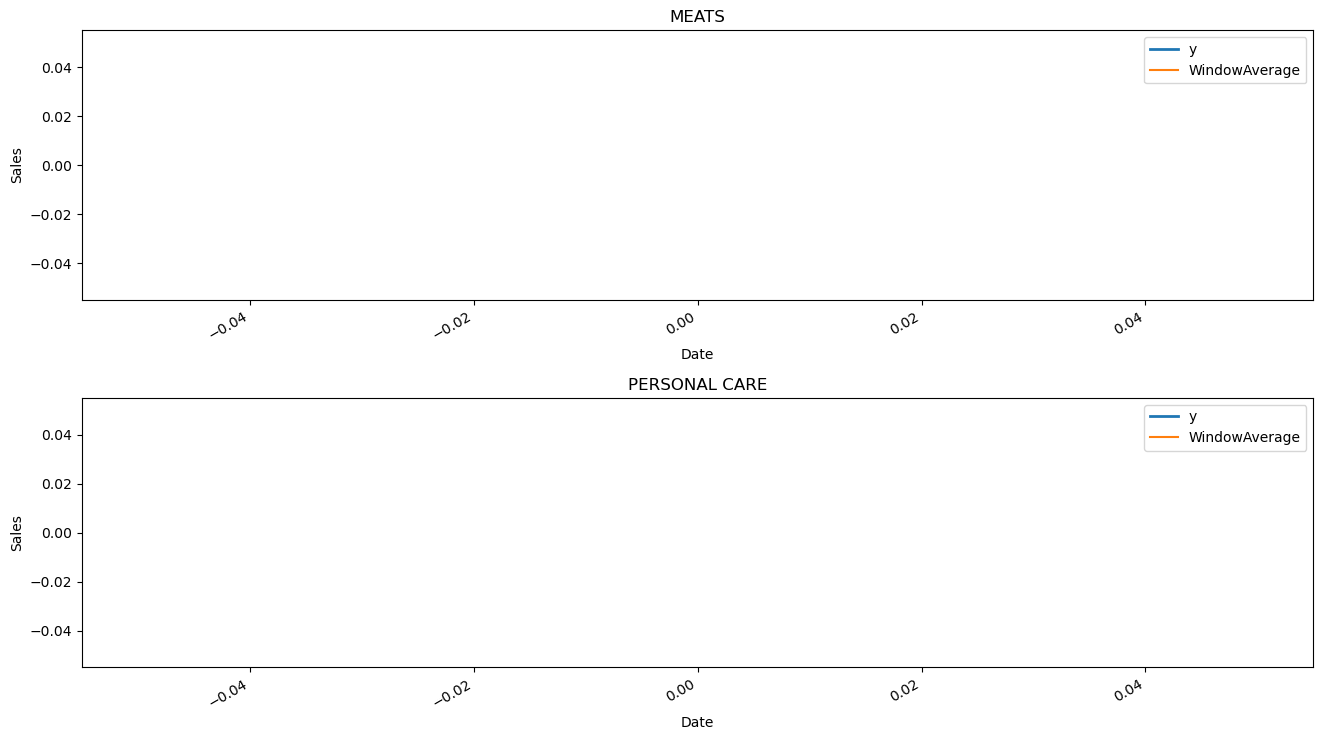

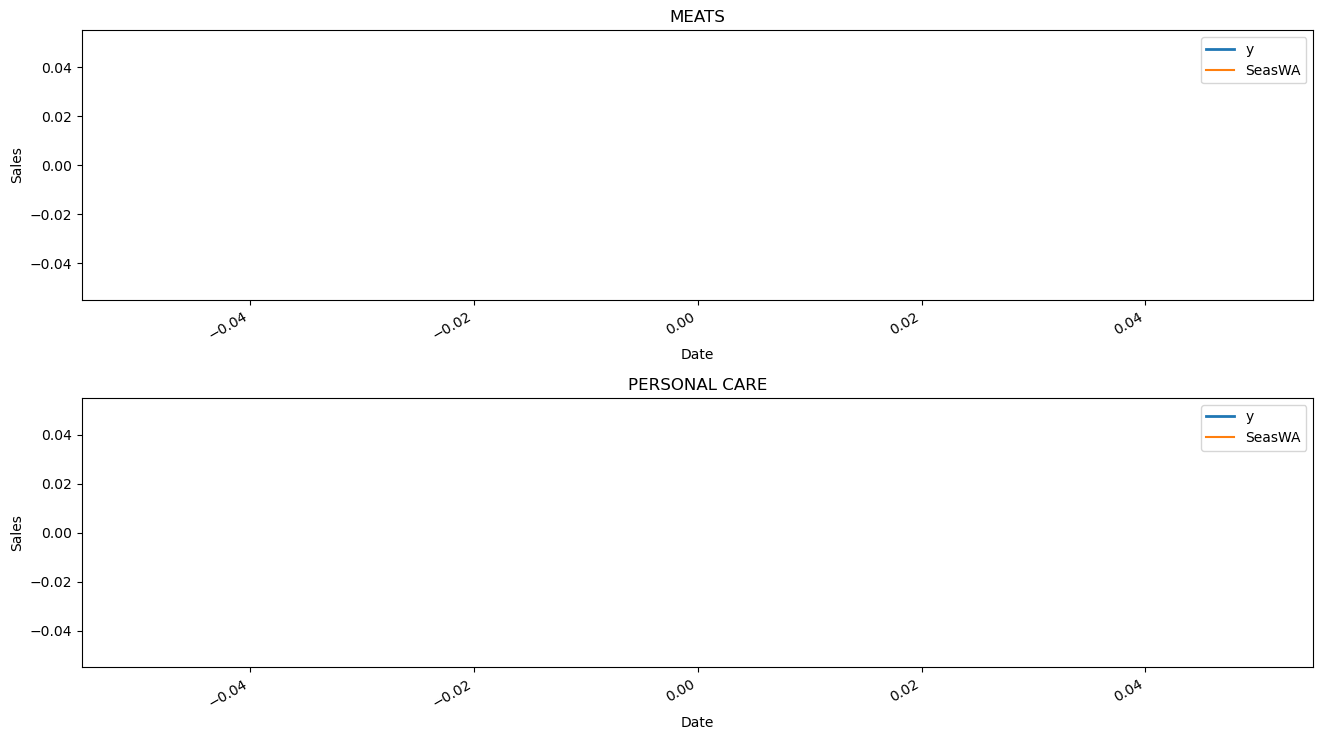

In [71]:
for model_ in ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA']:
    fig,ax = plt.subplots(2,1, figsize=(1280/96, 720/96))
    for ax_, family in enumerate(['MEATS', 'PERSONAL CARE']):
        p.loc[p['unique_id'] == family].plot(x='ds', y='y', ax=ax[ax_], label='y', title=family, linewidth=2)
        p.loc[p['unique_id'] == family].plot(x='ds', y=model_, ax=ax[ax_], label=model_)
        ax[ax_].set_xlabel('Date')
        ax[ax_].set_ylabel('Sales')
        if model_ in ['Naive', 'SeasonalNaive']:
            # ax[ax_].fill_between(p.loc[p['unique_id'] == family, 'ds'].values,
                                # p.loc[p['unique_id'] == family, f'{model_}-lo-90'], 
                                # p.loc[p['unique_id'] == family, f'{model_}-hi-90'], 
                                # alpha=0.2,
                                # color='orange')
            ax[ax_].set_title(f'{family} - Orange band: 90% confidence interval')
        ax[ax_].legend()
    fig.tight_layout()
    wmape_ = wmape(p['y'].values, p[model_].values)
    print(f'{model_} WMAPE: {wmape_:.2%}')